### Some theory!

This section describes how GPs work, and since "random functions" are an inherently abstract topic, we need a little more math than you're used to in order to describe them fully.  We'll be sure to describe the intuition behind the definitions though.  The rest of the course will be code and applications, so if this next section doesn't make complete sense when you go through it, don't worry about it and just move on.  Just revisit it later when you see an example that doesn't make complete sense.


# Making functions using **conditioning**

So GPs are functions, but where's the function part.  This is the last piece of the puzzle, promise.  We can use multivariate normals to make functions because of the concept of **conditioning**.  Conditioning is a relevant concept whenever we have multivariate random variables.  Think of a pair of random variables, "grass is wet", and "raining".  Together, they are a length two random vector, $(W, R)$.  We can ask: What's the probability that the grass is wet and that it's raining?  

Let's add the concept of conditioning.  What's the probability that the grass is wet, conditioned on (given) the fact that `raining=True`?  This is different than the probability that the grass is wet, if we know nothing about whether it's raining or not.  You can think of conditioning as adding information, or as taking something as "given".  You'll see this mathematically as a bar, $|$.  

- We can write the probability distribution of the length two random vector $(W, R)$ as, $p(W, R)$
- The probability that the grass is wet, given that it's raining is written $p(W | R)$.

If you're reminded of Bayes Theorem, that's good!  It's an understatement to say that the Bayesian approach statistics is all about conditional probability. 

### Chain rule of probability (Exercise maybe)

(If this is too much for the main lesson, this whole cell could be left as an exercise): It's not uncommon when tackling a problem to need something like Bayes theorem, but with more than two variables.  Enter the chain rule of probability.  I think this is a super useful rule and have personally used this theorem many times -- while doing actual real world work!  Using conditioning, we can factor out joint distributions of multiple random variables into manageable pieces.  Often, we know the distribution of the conditional distributions, but not the joint.   Here's the chain rule with three random variables:
$$
\begin{align}
p(A, B, C) 
  &= p(A | B, C) p(B, C) \\
  &= P(A | B, C) p(B | C) p(C) \\
\end{align}
$$
See how you can extend it to any number of random variables?

For example, it might be hard to think about the joint two-dimensional probability that it's raining and that the grass is wet, $p(W, R)$.  But, we can use the chain rule of probability to break it down.  We can look up the probability it rains on a given day for the climate where we live, and we also might know the probability the grass is wet, given that it's raining.  

All that lead up is for this exercise:  Use the chain rule of probability (and a little algebra) to derive Bayes theorem.

## Conditioning and multivariate normals

We actually already showed you a picture of what conditioning looks like for a two dimensional multivariate normal.  This was a few minutes ago, but let's revisit it as a code example of conditioning with a multivariate normal.

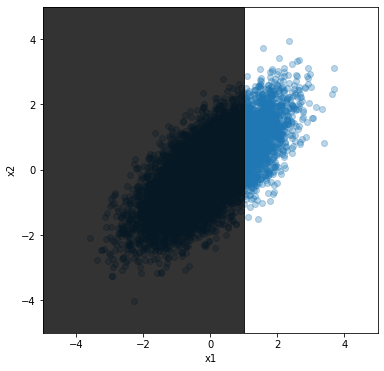

In [140]:
from matplotlib.patches import Rectangle

mu = [0.0, 0.0]
sigma1 = 1.0
sigma2 = 1.0
covariance = 0.7
cov = np.array([
    [sigma1, covariance],
    [covariance, sigma2]
])
samples = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov), 10_000)

x1 = samples[:, 0]
x2 = samples[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x1, x2, alpha=0.3)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_xlabel("x1");
ax.set_ylabel("x2");

ax.add_patch(Rectangle((-5, -5), 6, 10, alpha=0.8, color="k"));

Given that $x1 > 1$, what's the distribution of $x2$?  We can figure that out with a bit of code,

In [141]:
x = np.vstack((x1, x2)).T
ix = x[:, 0] > 1 # True if x1 > 1
conditional_samples = x[ix, :]

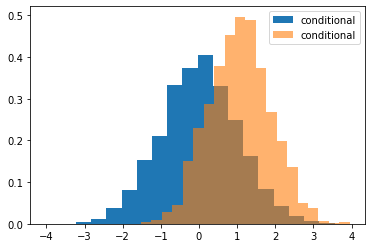

In [142]:
plt.hist(x[:, 1], 20, label='conditional', density=True);
plt.hist(conditional_samples[:, 1], 20, label='conditional', density=True, alpha=0.6);
plt.legend();

By placing our hand over the distribution where $x1 < 1$, we update our knowledge about $x2$ -- we can see that it's generally a bit higher.   

## GPs condition on themselves

Now, we split $x$ into two sections, which we label $x$ and $x_*$.  This might sound weird, but it's not too complicated.  You could say $x$ represents everything below zero, and $x_*$ represents everything above zero.  It doesn't matter where we put the boundary, just that we make two sections.  It's a bit weird, but the "$*$" notation will make more sense in a couple slides (hint: it's there to label the region as a forecast or a prediction).  We can rewrite the definition above as 

$$
\begin{bmatrix}
f(x_*) \\ f(x)
\end{bmatrix}
\sim
\mathcal{GP} \Bigg(
\begin{bmatrix}
0 \\ 0
\end{bmatrix},
\begin{bmatrix}
k(x_*, x_*') & k(x_*, x') \\
k(x, x_*') & k(x, x')
\end{bmatrix}
\Bigg)
$$

Rewriting the GP equation this way shows that it's a joint distribution over two sections of the same function $f(x)$ and $f(x_*)$ -- it's not any different than the probability of the grass being wet or whether it was raining that we had earlier, $p(W, R)$.  

It's a mouthful, but it's equivalent to think of a distribution over functions as a joint distribution over two parts of that function.  Since there are many $x's$ you could plug in, a distribution over functions is just inherently a joint distribution, and it doesn't matter how you section it up, or how many sections you make. 

The reason we section it up like this though is so we can *condition* $f(x_*)$ on $f(x)$.  We want $p\left(f(x_*) \mid f(x)\right)$.  Under the hood, the way you actually derive this is another application of Bayes theorem --  except for multivariate normals we can work it out the answer on paper, we don't need MCMC sampling.  This derivation is a bit long, so we won't include it, just show the result below.

## The most important equation for GPs
$$
f(x_*) \mid f(x)
\sim
\mathcal{GP}\left(
   k(x_*, x) k(x, x)^{-1} f(x) \,, k(x_*, x_*) - k(x_*, x) k(x, x)^{-1} k(x, x_*)\right) \,.
$$

Read this as: "The function $f(x_*)$ is distributed as a Gaussian process with mean $k(x_*, x) k(x, x)^{-1} f(x)$, and covariance function $k(x_*, x_*) - k(x_*, x) k(x, x)^{-1} k(x, x_*)$."  Like before, if we take a fixed set of $x$ values, *and* a fixed set of $x_*$ values and plug them in, we get a multivariate normal:

$$
\mathbf{f}_* \mid \mathbf{f}_x 
\sim
\mathcal{N}\left(
   \mathbf{K}_{*x} \mathbf{K}_{xx}^{-1} \mathbf{f}_x \,, \mathbf{K}_{**} - \mathbf{K}_{*x} \mathbf{K}_{xx}^{-1} \mathbf{K}_{x*}\right) \,.
$$

It's important to note that $k(x, x)^{-1}$ isn't just $1 / k(x, x)^{-1}$. What I'm using this notation to mean in this context is, plug your $x$s in, get the matrix $\mathbf{K}_{xx}$ (like we did in the code example above) and take the matrix inverse.  If that doesn't make sense to you, don't worry about it.  I just want to clear any potential confusion with the notation here.  



### Conditioning and predicting

Now let's extend our code example from above, and draw the distribution of $\mathbf{f}_*$.

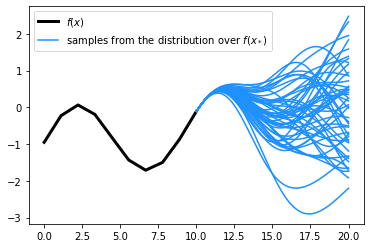

In [177]:
x = np.linspace(0, 10, 10)  # a fixed set of x's
cov = pm.gp.cov.ExpQuad(1, ls=3) # a covariance *function*
Kxx = cov(x[:, None]).eval() # evaluate the covariance function over the fixed set of x's, now it's a matrix K_xx
fx = pm.draw(pm.MvNormal.dist(mu=np.zeros(len(x)), cov=Kxx), 1)  # draw one sample of f_x.  

# Now we are going to condition f_* on f_x (using underscore s for star) using the formula above for f_* | f_x
xs = np.linspace(10, 20, 200)
Kxx_inv = np.linalg.pinv(Kxx) ## this is not a "numerically stable" way to calculate this, as you may find
Kxs = cov(x[:, None], xs[:, None]).eval()
Ksx = cov(xs[:, None], x[:, None]).eval()
Kss = cov(xs[:, None], xs[:, None]).eval()

mu = Ksx @ Kxx_inv @ fx
cov = Kss -  Ksx @ Kxx_inv @ Kxs
fs = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov), 50)  # draw 50 samples of f_* 

plt.plot(x, fx.T, lw=3, color="k", label="$f(x)$");
plt.plot(xs, fs.T, color="dodgerblue")
plt.plot(xs, fs[0, :], color="dodgerblue", label="samples from the distribution over $f(x_*)$") #overlay one for the legend
plt.legend();

So, like all things Bayesian, conditioning is how GPs generate forecasts.  So GPs are powered by **Bayes theorem**, where the data here are the observed function values (in black), and the parameters (usually called $\theta$) are the predictions $f(x_*)$.  

## Gaussian process as a prior

Let's do a quick sanity check -- in in the process, realize we've already defined how to use GPs as priors.  Let's ask, what happens if we don't have anything to condition on?  What to $f(x_*)$ when we have no $f(x)$?  Starting with, 

$$
f(x_*) \mid f(x)
\sim
\mathcal{GP}\left(
   k(x_*, x) k(x, x)^{-1} f(x) \,, k(x_*, x_*) - k(x_*, x) k(x, x)^{-1} k(x, x_*)\right) \,.
$$

If we have no $f(x)$, and no $x$ to condition on, then $k(x_*, x) = 0$, $k(x, x_*) = 0$ and $f(x) = 0$, so this simplifies to, 

$$
f(x_*) \sim \mathcal{GP}\left(0 \,, k(x_*, x_*) \right) \,.
$$

Which, other than the asterisk $*$ (which remember, what part of the function we labeled $*$ was pretty arbitrary), is the same as the definition of a GP.  When we aren't conditioned on any observed values of the function, what we have are just predictions with no data to anchor them.  While we back into it here, this is a **Gaussian process prior**.  

## Bayes theorem twice

Something that's confusing about GPs is that in practice, Bayes theorem happens twice.  Let's revisit our logistic regression example -- except this time, we'll use PyMC instead of coding the GP from scratch as a multivariate normal.  

### Bayes theorem the first time

The first time is when we fit the data.  In this example, our observations are 1's and 0's.  We know there is an underlying function $p(x)$ that generated it.  Since we're doing logistic regression with GPs, we assume $p(x)$ is a GP that's passed through a sigmoid function.  We call the GP $f(x)$, like above.  We aren't forecasting yet though, so we aren't worried yet about $f(x_*)$.  **To make predictions where we condition $f(x_*)$ on $f(x)$, we first have to estimate $f(x)$** -- which is what we did before.

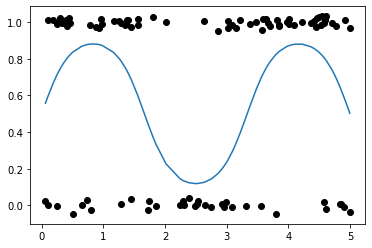

In [218]:
x = 5 * np.sort(np.random.rand(100))
p_true = at.sigmoid( 2 * np.sin(2 * np.pi * x * 0.3) ).eval()
y = np.random.binomial(1, p=p_true)

jitter = 0.02 * np.random.randn(len(x))
plt.plot(x, y + jitter, "ok");
plt.plot(x, p_true);

In [219]:
with pm.Model() as model:
    # Since we don't know them, we put distributions on the parameters of the kernel, like the lengthscale
    eta = pm.HalfNormal("eta", sigma=1)
    lengthscale = pm.Uniform("lengthscale", lower=1, upper=5)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
  
    ## All that math can be written in a couple lines of code
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=x[:, None])
    
    p = pm.Deterministic("p", at.sigmoid(f))
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(target_accept=0.9)

Compiling...
Compilation time =  0:00:01.724427
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:46.587374
Transforming variables...
Transformation time =  0:00:01.536888
Computing Log Likelihood...
Log Likelihood time =  0:00:01.685300


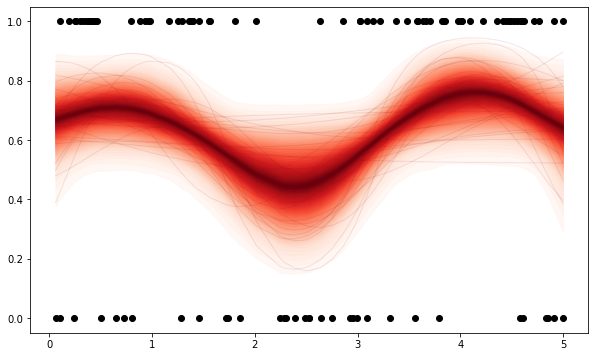

In [220]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

p = idata.posterior.p.stack(samples=['chain', 'draw']).values

pm.gp.util.plot_gp_dist(ax, p.T, x=x)
plt.plot(x, y, "ok");

### Bayes theorem a second time

Now that we have the posterior of $f(x)$, let's define the conditional distribution $f(x_*)$ where we condition on the posterior of $f(x)$.  In PyMC, we take the same `gp` object we already have, and this time call the `.conditional` method (instead of `.prior`).  

In [221]:
xs = np.linspace(np.max(x), 8, 100)
with model:
    f_pred = gp.conditional("f_pred", Xnew=xs[:, None], jitter=1e-6)
    p_pred = pm.Deterministic("p_pred", pm.math.sigmoid(f_pred))

We draw from it using posterior predictive sampling, meaning, we don't need MCMC because we can use the GP conditioning formula we wrote down above.

In [222]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["f_pred", "p_pred"]))

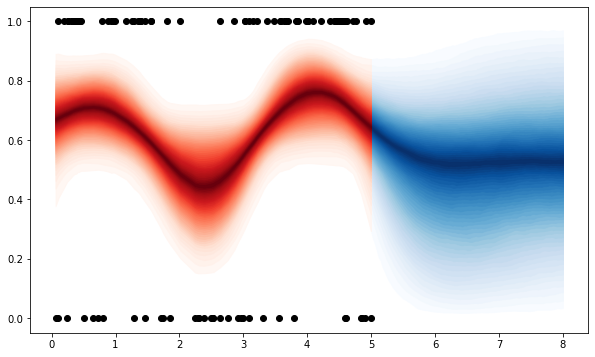

In [225]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

p = idata.posterior.p.stack(samples=['chain', 'draw']).values
p_pred = idata.posterior_predictive.p_pred.stack(samples=['chain', 'draw']).values

pm.gp.util.plot_gp_dist(ax, p_pred.T, x=xs, palette="Blues", plot_samples=False)
pm.gp.util.plot_gp_dist(ax, p.T, x=x, plot_samples=False)
plt.plot(x, y, "ok");

The predictions are shown in blue. 

## Two distributions here, but it's really just one

These are the takeaways here:
- A GP prior is just a prior, but for GPs, it's a distribution over functions.
- Conditioning gives you the GP posterior, which is also a distribution over functions.
- If you condition on nothing, that's just the prior.

Both the GP prior and the posterior take an arbitrary $x$ and give you a distribution over functions for the output.  